In [1]:
import pandas as pd

df = pd.read_excel("data.xlsx")
df

,age,income,student,credit_rating,buys_computer
0,< = 30,high,no,fair,no
1,< = 30,high,no,excellent,no
2,31 ... 40,high,no,fair,yes
3,> 40,medium,no,fair,yes
4,> 40,low,yes,fair,yes
5,> 40,low,yes,excellent,no
6,31 ... 40,low,yes,excellent,yes
7,< = 30,medium,no,fair,no
8,< = 30,low,yes,fair,yes
9,> 40,medium,yes,fair,yes


In [2]:
df['age'].replace("31 ... 40", "31 - 40", inplace=True)

In [3]:
# A1
# Functions to calculate the entropy and information_gain
import math

# Calculate entropy
def entropy(p):
    if p == 0 or p == 1:
        return 0
    return -p * math.log2(p) - (1 - p) * math.log2(1 - p)

# Calculate information gain for a feature
def information_gain(data, feature_name, target_name):
    # Calculate entropy for the entire dataset
    # normalize = True; If True then the object returned will contain 
    # the relative frequencies of the unique values
    total_entropy = entropy(data[target_name].value_counts(normalize=True)[0])
    
    # Calculate conditional entropy for the feature
    feature_entropy = 0
    for value in data[feature_name].unique():
        subset = data[data[feature_name] == value]
        weight = len(subset) / len(data)
        subset_entropy = entropy(subset[target_name].value_counts(normalize=True)[0])
        feature_entropy += weight * subset_entropy
    
    # Calculate information gain
    info_gain = total_entropy - feature_entropy
    return info_gain

# Calculate information gain for each feature
target_name = 'buys_computer'
information_gains = {}
for feature in df.columns.difference([target_name]):
    information_gains[feature] = information_gain(df, feature, target_name)

# Find the feature with the highest information gain
print(information_gains)
root_node = max(information_gains, key=information_gains.get)
print("The root node feature is: ", root_node)

{'age': 0.24674981977443933, 'credit_rating': 0.04812703040826949, 'income': 0.02922256565895487, 'student': 0.15183550136234159}
The root node feature is:  age


In [4]:
# A2
# There are a lot of preprocessing steps for making a decision tree
# classifier since it only accepts numeric data, hence we initially
# convert to one hot encoding before making a decision tree
import numpy as np
from sklearn.model_selection import train_test_split

X = df.iloc[:, :df.shape[0] - 1]
y = df['buys_computer']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [5]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_transformer(df):
    
    jobs_encoder = OneHotEncoder(handle_unknown='ignore')
    
    df_temp = pd.DataFrame()
    
    # For dataframe objects
    if len(df.shape) == 2:
        for i in df.columns:
            transformed = jobs_encoder.fit_transform(df[i].to_numpy().reshape(-1, 1))
            #Create a Pandas DataFrame of the hot encoded column
            ohe_df = pd.DataFrame(transformed.toarray(), columns=jobs_encoder.get_feature_names_out([i]).tolist())
            #concat with original data
            df_temp = pd.concat([df_temp, ohe_df], axis=1)
    # For series objects
    else:
        transformed = jobs_encoder.fit_transform(df.to_numpy().reshape(-1, 1))
        #Create a Pandas DataFrame of the hot encoded column
        ohe_df = pd.DataFrame(transformed.toarray(), columns=jobs_encoder.get_feature_names_out([df.name]).tolist())
        #concat with original data
        df_temp = pd.concat([df_temp, ohe_df], axis=1)

    del jobs_encoder    
    
    return df_temp

# Transform all features in the form of one hot encoding, so that they
# can be passed as arguments to methods to DecicisionTreeClassifier
x_train = one_hot_transformer(x_train)

In [6]:
y_train = one_hot_transformer(y_train)

In [7]:
y_test = one_hot_transformer(y_test)

In [8]:
x_test = one_hot_transformer(x_test)

In [9]:
# To check for any naming descrepancies between x_test and x_train
x_test.columns.tolist() == x_train.columns.tolist()

False

In [10]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

model = model.fit(x_train, y_train)
print("Depth of tree is: ", model.get_depth())
print("Training set accuracy: ", model.score(x_train, y_train))

Depth of tree is:  1
Training set accuracy:  1.0


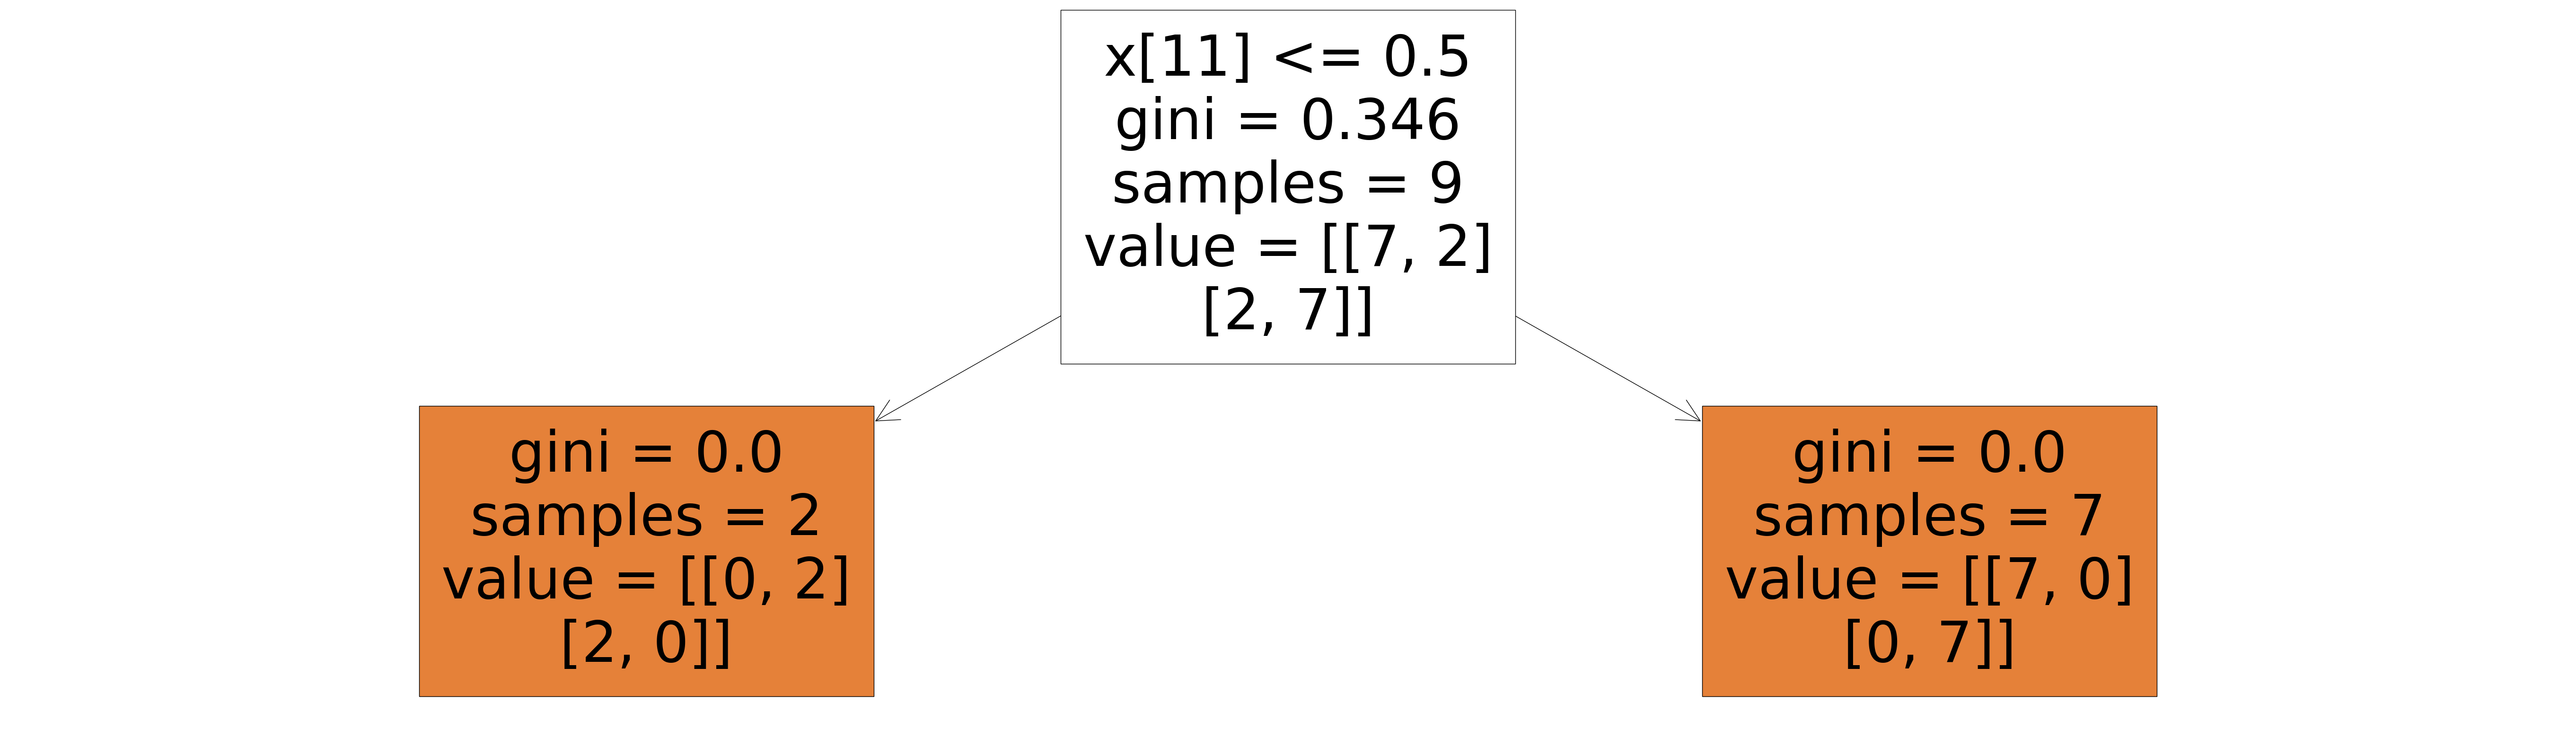

In [11]:
# A3
# Plotting a decision tree
import matplotlib.pyplot as plt

from sklearn import tree

plt.figure(figsize=(70, 20))
tree.plot_tree(model, filled=True)
plt.show()

In [12]:
# A4
# Now we perform the same steps on project dataset

df1 = pd.read_csv("lab3.csv")

In [13]:
ham = df1[df1['Category'] == 'ham']
spam = df1[df1['Category'] == 'spam']
ham = ham.sample(spam.shape[0])

# Now combine these to form a dataset.
dataset = pd.concat([ham, spam], ignore_index=True)

In [14]:
x_trn, x_tst, y_trn, y_tst = train_test_split(dataset['Message'], dataset['Category'], test_size=0.3)

from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer()
x_trn = tfid.fit_transform(x_trn).toarray()
x_tst = tfid.transform(x_tst).toarray()
y_trn = tfid.transform(y_trn).toarray()
y_tst = tfid.transform(y_tst).toarray()

In [15]:
from sklearn.metrics import accuracy_score

dtree = DecisionTreeClassifier()

dtree.fit(x_trn, y_trn)
pred1 = dtree.predict(x_tst)
pred2 = dtree.predict(x_trn)

trn_acc_dt = accuracy_score(pred2, y_trn)
tst_acc_dt = accuracy_score(pred1, y_tst)

print("Training accuracy: ", trn_acc_dt)
print("Test accuracy: ", tst_acc_dt)

Training accuracy:  1.0
Test accuracy:  0.8997772828507795


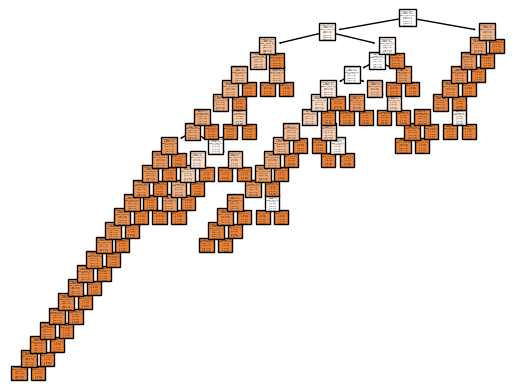

In [16]:
tree.plot_tree(dtree, filled=True)
plt.show()

Training accuracy:  0.9043062200956937
Test accuracy:  0.8708240534521158


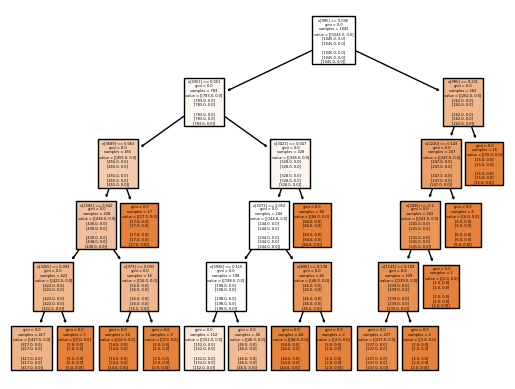

In [17]:
# A5
# Same project data but with added constraint of max_depth = 5
dtree1 = DecisionTreeClassifier(max_depth=5)

dtree1.fit(x_trn, y_trn)
pred1 = dtree1.predict(x_tst)
pred2 = dtree1.predict(x_trn)
print("Training accuracy: ", accuracy_score(pred2, y_trn))
print("Test accuracy: ", accuracy_score(pred1, y_tst))

tree.plot_tree(dtree1, filled=True)
plt.show()

Training accuracy:  1.0
Test accuracy:  0.9020044543429844


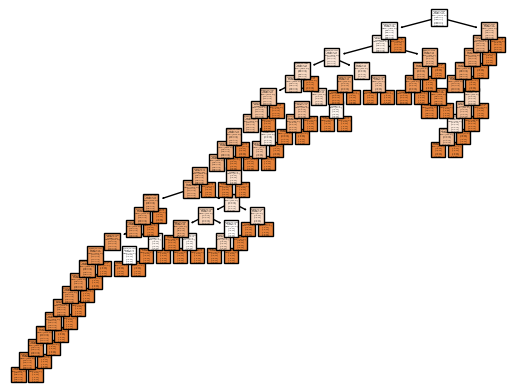

In [18]:
# A6
# The default criterion is changed to entropy to study differences

dtree2 = DecisionTreeClassifier(criterion="entropy")

dtree2.fit(x_trn, y_trn)
pred1 = dtree2.predict(x_tst)
pred2 = dtree2.predict(x_trn)
print("Training accuracy: ", accuracy_score(pred2, y_trn))
print("Test accuracy: ", accuracy_score(pred1, y_tst))

tree.plot_tree(dtree2, filled=True)
plt.savefig("output.png")
plt.show()
# Default criterion is gini which calculates quality of split based on
# gini impurity and entropy uses shannon information gain

In [19]:
# A7
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier

rlf = RandomForestClassifier(max_depth=2, random_state=0)
rlf.fit(x_trn, y_trn)
pred1 = rlf.predict(x_tst)
pred2 = rlf.predict(x_trn)

trn_acc_rfc = accuracy_score(pred2, y_trn)
tst_acc_rfc = accuracy_score(pred1, y_tst)

In [20]:
perf_metric = pd.DataFrame([[trn_acc_dt, tst_acc_dt], [trn_acc_rfc, tst_acc_rfc]], index=["Decision Tree", "Random Forest"], columns=["Training", "Test"])
perf_metric

,Training,Test
Decision Tree,1.000000,0.899777
Random Forest,0.910048,0.890869
